In [51]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt

import oqs_emission_mps as omps
import pulse
import cmps_utils
import tncontract as tn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


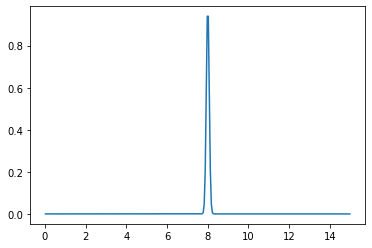

In [52]:
state = omps.DrivenModulatedTLS(0.05, 300, 1.0)
delta = pulse.ConstantPulse(0)
Omega_x = pulse.GaussianPulse(1.0, 8.0, 0.1)
Omega_y = pulse.ConstantPulse(0)
mps = state.get_mps([delta, Omega_x, Omega_y])

plt.plot(state.times, Omega_x(state.times))

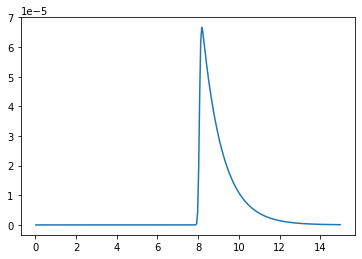

In [53]:
single_ph_proj = cmps_utils.compute_single_ph_proj(mps)
plt.plot(state.times, np.abs(single_ph_proj)**2)

/Users/rahultrivedi/anaconda3/envs/quantum/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


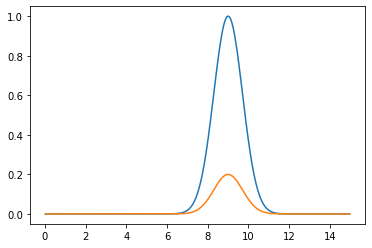

In [54]:
single_ph_pulse = pulse.GaussianPulse(1.0, 9.0, 1.0)
target_mps = cmps_utils.single_ph_state_as_mps(
    single_ph_pulse(state.times))
target_mps_proj = cmps_utils.compute_single_ph_proj(
    target_mps)

plt.plot(state.times, single_ph_pulse(state.times))
plt.plot(state.times, target_mps_proj)

In [55]:
state.get_inner_prod_gradient(
    target_mps, [delta, Omega_x, Omega_y])

[[0j,
  (-8.504458336907483e-22+0j),
  (-2.431865950094623e-21+0j),
  (-5.357879867909753e-21+0j),
  (-1.0744719464150737e-20+0j),
  (-2.0612516940225347e-20+0j),
  (-3.859853143062242e-20+0j),
  (-7.121809738957558e-20+0j),
  (-1.3008212097914337e-19+0j),
  (-2.3577609775353886e-19+0j),
  (-4.246096054325958e-19+0j),
  (-7.602980639548608e-19+0j),
  (-1.354073581323606e-18+0j),
  (-2.399122670966824e-18+0j),
  (-4.229242908075192e-18+0j),
  (-7.418217676772709e-18+0j),
  (-1.294727471780072e-17+0j),
  (-2.2485763763720175e-17+0j),
  (-3.8859079164976554e-17+0j),
  (-6.682455400578043e-17+0j),
  (-1.1435110465606207e-16+0j),
  (-1.9471832002029337e-16+0j),
  (-3.2994116646433516e-16+0j),
  (-5.563272644737158e-16+0j),
  (-9.334458724086814e-16+0j),
  (-1.558524568690038e-15+0j),
  (-2.5894326898862583e-15+0j),
  (-4.2811732105576224e-15+0j),
  (-7.0435064544797665e-15+0j),
  (-1.1531445151487386e-14+0j),
  (-1.8786593376012206e-14+0j),
  (-3.045668298427842e-14+0j),
  (-4.9134693669599

In [61]:
target_mps.nsites

300

In [63]:
target_mps.dim

AttributeError: 'MatrixProductState' object has no attribute 'dim'

In [70]:
x = np.kron(np.array([[1, 2, 3]]), np.array([[1, 1, 5]]))

In [71]:
x

array([[ 1,  1,  5,  2,  2, 10,  3,  3, 15]])